In this notebook, we will create a "golden set" of sentences, that need to be voiced over. There are certain requirements these sentences must follow.

1. They shouldn't be too short or too long. The length of the sentence determines the length of the voiceline, and the maximal length of the voiceline determines how much memory will be consumed per voiceline on training.
2. They shouldn't contain abbreviations, shortenings, etc. TortoiseTTS doesn't know how to pronounce those. Even the punctuation besides `,` and `.` is not advisable, because TortoiseTTS constantly mixes up long and short dashes: "well-known" can be pronounced as "well, known"
3. They should not contain too much of the complicated words, such as `aminopyridine` or `bourgeoisie`. Tortoise often fails on those.
4. They should not contain clearly non-English proper names. Tortoise will pronounce them in the most wildest way imaginable. Moreover, the Golden Dataset algorithm tries to equalize representation of the unusual phonemes, and as a result **all** the non-English names will be included in the Golden Dataset. 

2 and 3 effectively disqualifies Wikipedia, while 4 disqualifies most of the literature. In my experience, the best quality was achieved with The Song of Ice and Fire by R.G.G. Martin, who mostly uses English even for proper names. Robert Jordan was also acceptable, however, `Gawyn` or `Moghedien` are clearly beyond the requirement 4.

You don't need to have a lot of sentences for that, I had just 40 Megabytes.

Now, suppose someone gave you a 40 MB of text, one sentence per line and no weird symbols, and stored it in `Loc.data_folder/'text.txt'` You can use the following code to filter for length, to exclude lines with excessive punctuation and proper names.

```python
from kaia.ml.voice_cloning.golden_dataset.filtering import filter_file

lines = filter_file(Loc.data_folder/'text.txt')

FileIO.write_json(list(pd.Series(lines).sample(5000)), 'files/lines.json')
```

I did it, took 5000 random lines and placed in `files/lines.json`


In [1]:
from kaia.infra import FileIO

lines = FileIO.read_json('files/lines.json')

I love pandas, this is why we're going to process everything with it:

In [2]:
import pandas as pd

sentences_df = pd.DataFrame(lines)
sentences_df.columns=['text']
sentences_df['sentence_id'] = list(range(sentences_df.shape[0]))
sentences_df.head()

,text,sentence_id
0,"Above a darker yellow sash, she was quite bare...",0
1,Those leeches that he loves so well sucked all...,1
2,Jon told the story of how he and Robb had foun...,2
3,As though I were a puppy he was going to have ...,3
4,I told her if she caused you any bother again ...,4


Now, we want to remove all the sentences that contains weird phonemas. Here is a carefully selected, handpicked list of phonemes that are truly part of english language, in the way `espeak` writes them:

In [3]:
allowed_phonemes = [
    'ɪ', 'n', 's', 't', 'k', 'ə', 'ɹ', 'l', 'd', 'm', 'æ', 'ɛ', 'z', 'p', 'b', 
    'eɪ', 'ɑː', 'ɚ', 'oʊ', 'f', 'iː', 'aɪ', 'i', 'ᵻ', 'ɡ', 'ŋ', 'uː', 'v', 'ɾ', 
    'ʃ', 'ʌ', 'dʒ', 'h', 'ɐ', 'əl', 'w', 'j', 'ɜː', 'ɑːɹ', 'tʃ', 'iə', 'θ', 'ɔː', 
    'aʊ', 'oːɹ', 'ɔːɹ', 'ʊ', 'ɔ', 'oː', 'ɔɪ', 'ʊɹ', 'ɛɹ', 'ɪɹ', 'ʒ', 'aɪɚ', 'ð', 
    'aɪə', 'ʔ', 'n̩'
]

Now, we need to know how to pronounce all our sentences. Here's the first pain: espeak. It is not easily installable on Windows machine. It can be done, but it's laborious. Moreover, installation of CoquiTTS on Windows is also very painful. For these reasons, I have created a docker container that we will use both for training and for phonemes extraction.

In [4]:
from kaia.infra import Loc
from kaia.ml.voice_cloning.coqui_training_container import CoquiTrainingContainerInstaller, CoquiTrainingContainerSettings

FileIO.write_json(lines, Loc.data_folder/'phonemizer.input.json')
installer = CoquiTrainingContainerInstaller(CoquiTrainingContainerSettings())
#installer.install_if_not_installed()
#installer.phonemize_endpoint.run()
phonemes = FileIO.read_json(Loc.data_folder/'phonemizer.output.json')

In [5]:
sentences_df['phonemization'] = phonemes
sentences_df.head()

,text,sentence_id,phonemization
0,"Above a darker yellow sash, she was quite bare...",0,ə/b/ʌ/v ɐ d/ɑːɹ/k/ɚ j/ɛ/l/oʊ s/æ/ʃ ʃ/iː w/ʌ/z ...
1,Those leeches that he loves so well sucked all...,1,ð/oʊ/z l/iː/tʃ/ɪ/z ð/æ/t h/iː l/ʌ/v/z s/oʊ w/ɛ...
2,Jon told the story of how he and Robb had foun...,2,dʒ/ɑː/n t/oʊ/l/d ð/ə s/t/oː/ɹ/i ʌ/v h/aʊ h/iː ...
3,As though I were a puppy he was going to have ...,3,æ/z ð/oʊ aɪ w/ɜː/ɹ ɐ p/ʌ/p/i h/iː w/ʌ/z ɡ/oʊ/ɪ...
4,I told her if she caused you any bother again ...,4,aɪ t/oʊ/l/d h/ɜː ɪ/f ʃ/iː k/ɔː/z/d j/uː ɛ/n/i ...


Now, we compute how many times each letter and each phoneme occurs in each sentence. This will help us to establish sentences' value. Note that for VITS training you probably can only look at phonemes, as letters won't reach the network anyway.

In [6]:
from kaia.ml.voice_cloning.golden_dataset.features import compute_features

features_df = compute_features(sentences_df, allowed_phonemes)
features_df.head()

,sentence_id,feature,cnt
0,0,_a,9
1,0,_b,2
2,0,_o,5
3,0,_v,1
4,0,_e,11


Now we can run the alhorithm:

In [7]:
from kaia.ml.voice_cloning.golden_dataset.algorithm import GoldenSetAlgorithm

banned_sentences_ids = [
]

banned_words = [

]

algorithm = GoldenSetAlgorithm(sentences_df, features_df)
selected_sentences = algorithm.run(100, banned_sentences_ids, banned_words, False)

We can control that the minimal amout of times the feature occures in the dataset is growing steadily:

<Axes: >

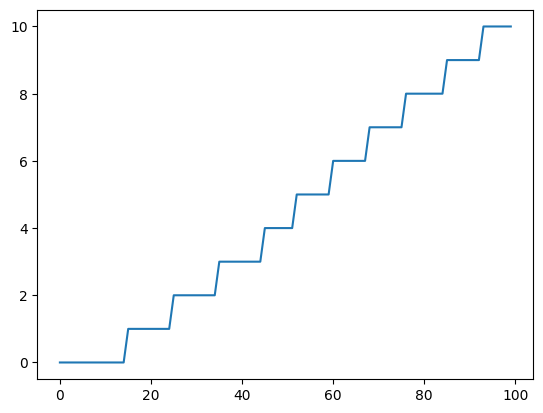

In [8]:
result_df = features_df.loc[features_df.sentence_id.isin(selected_sentences)]
result_df = result_df.pivot_table(index='sentence_id', columns='feature', values='cnt').fillna(0)
result_df = result_df.loc[selected_sentences]
result_df = result_df.reset_index(drop=True)
result_df = result_df.cumsum()
result_df.min(axis=1).plot()

As we see, it really doesn't take a lot of lines to achieve a good representation for the phonemes and letters! 

In [9]:
result = algorithm.save_result(selected_sentences)

And now we can store the dataset in `files` folder:

```
FileIO.write_json(result, 'files/golden_set.json')
```